<font size="4"><b>Predictive Analysis of the Stack Overflow response rate with Google BigQuery</b></font>

Stack Overflow is the largest online community for programmers to learn, share their knowledge, and
advance their careers. Updated on a quarterly basis, this BigQuery dataset includes an archive of Stack
Overflow content, including posts, votes, tags, and badges. This is a real-world data set published
publicly on Google BigQuery. This dataset contains 16 tables with the number of rows ranging from 4-32
million. The goal of this project is to predict the response time based on various features of a question
posted on Stack Overflow.

In [725]:
#enable API
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/Users/varuni/Desktop/stackoverflowanalysisproject_bq_key.json'

In [726]:
#get necessary libraries
import numpy as np 
import pandas as pd 
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [727]:
client = bigquery.Client()
stackoverflow_reference = client.dataset('stackoverflow', project='bigquery-public-data')
#type(stackoverflow_reference)


<font size="4"><b>Data Acquisition</b></font>



The following steps were carries out to acquire the data from the Google Cloud Platform: <br><br>
1) Enable Google BigQuery API on the Google Cloud Platform <br>
2) Get authentication for Jupyter Notebook by obtaining a service account key for the BigQuery in a JSON file <br>
3) Install Google BigQuery API client libraries for Python on local computer <br>
4) Set the environment variable GOOGLE_APPLICATION_CREDENTIALS for your python script <br><br>

Once these steps were successfully completed, the data could be directly analyzed from your Jupyter Notebook console. Subsequently, the data set was analyzed by applying SQL (either standard or legacy format) on Google BigQuery. 


In [728]:
stackoverflow_dataset = client.get_dataset(stackoverflow_reference)

In [729]:
#get list of tables
[x.table_id for x in client.list_tables(stackoverflow_dataset)]

['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [730]:
posts_questions_tb=client.get_table(stackoverflow_dataset.table('posts_questions'))
type(posts_questions_tb)

google.cloud.bigquery.table.Table

In [731]:
#table commands
[command for command in dir(posts_questions_tb) if not command.startswith('_')]

['clustering_fields',
 'created',
 'dataset_id',
 'description',
 'encryption_configuration',
 'etag',
 'expires',
 'external_data_configuration',
 'friendly_name',
 'from_api_repr',
 'from_string',
 'full_table_id',
 'labels',
 'location',
 'modified',
 'num_bytes',
 'num_rows',
 'partition_expiration',
 'partitioning_type',
 'path',
 'project',
 'range_partitioning',
 'reference',
 'require_partition_filter',
 'schema',
 'self_link',
 'streaming_buffer',
 'table_id',
 'table_type',
 'time_partitioning',
 'to_api_repr',
 'to_bqstorage',
 'view_query',
 'view_use_legacy_sql']

<font size="4"><b>Exploratory Data Analysis: Complete Stack Overflow dataset on GCP</b></font>


In [732]:
#Compute % of questions answered for each year
query1 = """
    SELECT
      EXTRACT(YEAR FROM creation_date) AS Year,
      COUNT(*) AS Number_of_Questions,
      SUM(IF(answer_count > 0, 1, 0)) AS Number_Questions_with_Answers,
      ROUND(100 * SUM(IF(answer_count > 0, 1, 0)) / COUNT(*), 1) AS Percent_Questions_with_Answers
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    GROUP BY Year
    ORDER BY Year
"""


In [733]:
query_job = client.query(query1)
questions_answered_df=query_job.to_dataframe()
questions_answered_df

,Year,Number_of_Questions,Number_Questions_with_Answers,Percent_Questions_with_Answers
0,2008,57950,57882,99.9
1,2009,342579,341348,99.6
2,2010,692334,685609,99.0
3,2011,1193750,1162857,97.4
4,2012,1635435,1551938,94.9
5,2013,2048685,1882867,91.9
6,2014,2153444,1911212,88.8
7,2015,2207477,1913239,86.7
8,2016,2210822,1878810,85.0
9,2017,2127273,1772869,83.3


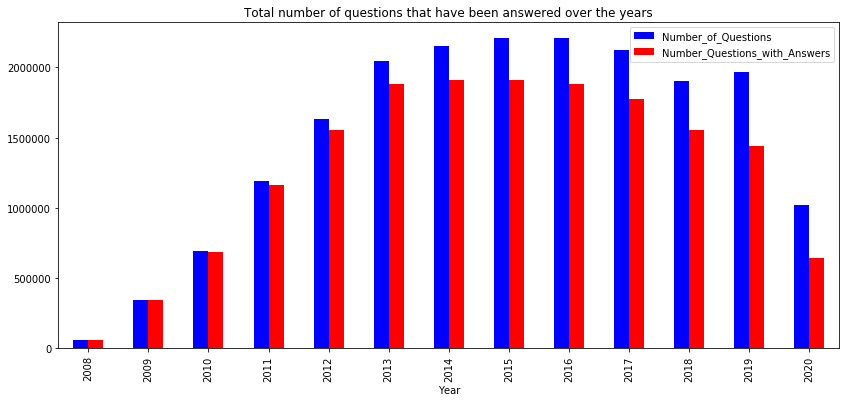

In [593]:
questions_answered_df.plot(x="Year",y=["Number_of_Questions","Number_Questions_with_Answers"], kind="bar",color=['b','r'],
                           figsize=(14,6), title='Total number of questions that have been answered over the years');

In the above query, the percentage of questions answered for each year was calculated. This is
illustrated in Fig 1 where the blue bars represent the number of questions asked each year and the red
bard represents the questions with answers. We observe that almost 100% of the questions have been
answered in the starting years of StackOverflow till 2010 and then the % of questions without answers
increases, with the highest % of unanswered questions in 2019 yet.

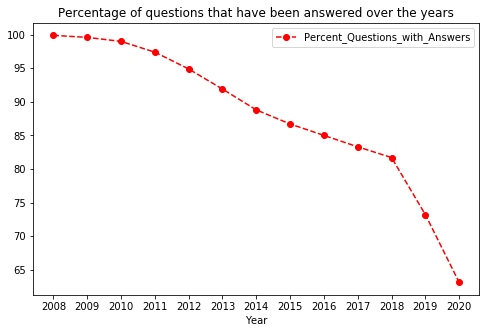

In [739]:
questions_answered_df.plot(x="Year",y="Percent_Questions_with_Answers", linestyle='--', marker='o', color='r',
                           xticks=np.arange(2008,2021,1),figsize=(8,5), title='Percentage of questions that have been answered over the years');


We directly plot the yearly % of questions with
answers. With the drastic drop going from year 2018 to 2019, we can ask whether it’s a matter of lower
quality questions or lower number of accepted answers posted on Stack Overflow. Let’s look into this in
more detail below.

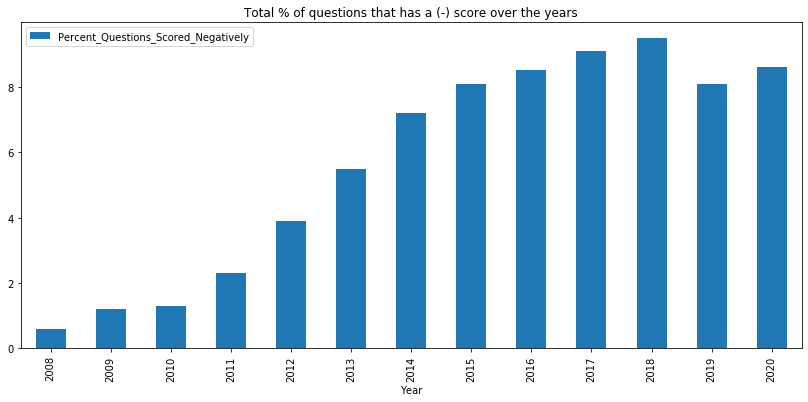

In [741]:
query2 = """SELECT EXTRACT(YEAR FROM creation_date) AS Year,
              COUNT(*) AS Number_of_Questions,
                ROUND(SUM(IF(score < 0, 1, 0))*100/COUNT(*), 1) AS Percent_Questions_Scored_Negatively
                FROM `bigquery-public-data.stackoverflow.posts_questions`
                GROUP BY Year
                ORDER BY Year"""

query_job = client.query(query2)
negative_score_df=query_job.to_dataframe()
#negative_score_df

negative_score_df.plot(x="Year",y="Percent_Questions_Scored_Negatively", kind="bar",
                           figsize=(14,6), title='Total % of questions that has a (-) score over the years');
#The fraction of negatively scored questions ave increased consisitenly over the years, with a platuea between 2017-2018 
#and a slight dip observed in 2019. 


Users on Stack Overflow have the capability to give a negative rating to posted questions depending on
its quality. The site also keeps track of and reports on the number of up and down votes and the number
of views received, which indicate how valuable and visible the content was to the community. In Fig 3,
we see that the number of negatively scored questions shows a general upward trend till 2018 and
actually decreases in 2019.

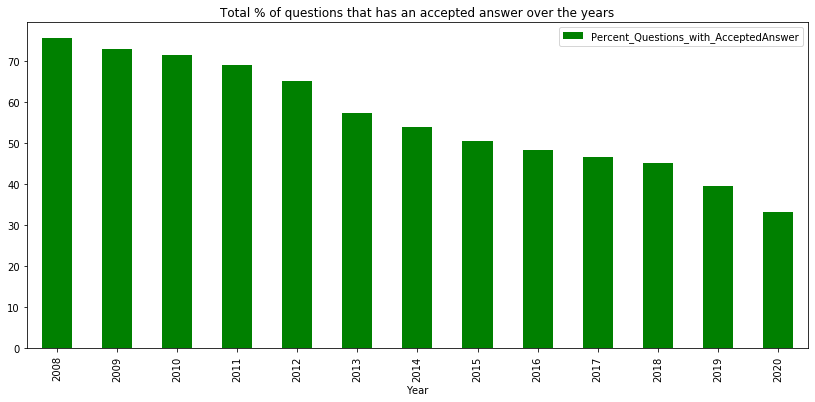

In [742]:
#What is the percentage of questions with an accepted answers over the years?
acceptedanswers_query="""
    SELECT EXTRACT(YEAR FROM creation_date) AS Year, 
        ROUND(SUM(IF(accepted_answer_id IS NOT NULL, 1, 0))*100/COUNT(*), 1) AS Percent_Questions_with_AcceptedAnswer
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    GROUP BY Year
    ORDER BY Year """
query_job = client.query(acceptedanswers_query)
acceptedanswers_df=query_job.to_dataframe()
#acceptedanswers_df
acceptedanswers_df.plot(x="Year",y="Percent_Questions_with_AcceptedAnswer", kind="bar",color='g',
                           figsize=(14,6), title='Total % of questions that has an accepted answer over the years');


While there is a general downward trend of the percentage of questions with an accepted answer from
2008 (Fig 4), there is a significant drop going from 2018 to 2019. Thus, we can conclude that the cause
for a high percentage of unanswered questions in 2019 is due to the lack of unaccepted answers and not
as a result of negatively scored questions.

The site provides a variety of means by which users classify and evaluate content, which serves to
organize the massive amount of content on the site and make it easier for users to find what is most
relevant and useful. These include tags that identify the programming language, operating system,
framework, library, and other technologies that a question addresses. Additionally, a given question can
have multiple tags. If we are interested in studying the distribution of questions across domains, we
need to separate tag under its own category.

In [745]:
#Top ten most popular tags 
tags_query = """
        SELECT tag,COUNT(*) count
        FROM (
              SELECT body AS question, SPLIT(tags, '|') AS tags
                FROM `bigquery-public-data.stackoverflow.posts_questions` 
            ), UNNEST(tags) tag
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10"""
query_job = client.query(tags_query)
popular_tags_df=query_job.to_dataframe()
popular_tags_df


,tag,count
0,javascript,2018226
1,java,1678002
2,python,1444084
3,c#,1409853
4,php,1353125
5,android,1277073
6,html,995371
7,jquery,987508
8,c++,674084
9,css,665534


We observe that Javascript is the most popular tag on Stack Overflow with over a 18% margin over the
second most popular tag, Java. It is rather interesting that three out of the ten most popular tags are
related to Java.

Furthermore, the average length for questions under each of these most popular tags were studied. This
was implemented by executing a parameterized SQL query.

In [746]:
#get the length of questions for the most popular tags
#run a parameterized query to get the questions for the most popular tags

tags_list=popular_tags_df['tag'].values.tolist()
print(tags_list)
question_length_query="""
        SELECT tag, question
        FROM (
              SELECT body AS question, SPLIT(tags, '|') AS tags
                FROM `bigquery-public-data.stackoverflow.posts_questions` 
            ), UNNEST(tags) tag  
        WHERE tag IN UNNEST(@tagnames)
        LIMIT 5000"""

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("tagnames", "STRING", tags_list),
    ]
)


['javascript', 'java', 'python', 'c#', 'php', 'android', 'html', 'jquery', 'c++', 'css']


In [747]:
query_job = client.query(question_length_query, job_config=job_config)

In [748]:
question_length_df=query_job.to_dataframe()
question_length_df.head()

,tag,question
0,javascript,<p>I'm using <code>ExtractTextPlugin</code> wi...
1,c#,<p>I want to create a simple SQL table in Visu...
2,javascript,<p>I have a list of items where an item is som...
3,html,<p>I have a list of items where an item is som...
4,css,<p>I have a list of items where an item is som...


In [749]:
question_length_df.loc[:,'length_of_question'] = question_length_df.loc[:,'question'].apply(len)

In [750]:
question_length_df.head(10)

,tag,question,length_of_question
0,javascript,<p>I'm using <code>ExtractTextPlugin</code> wi...,527
1,c#,<p>I want to create a simple SQL table in Visu...,1284
2,javascript,<p>I have a list of items where an item is som...,1795
3,html,<p>I have a list of items where an item is som...,1795
4,css,<p>I have a list of items where an item is som...,1795
5,android,<p>I have a map consisting of a number of line...,1296
6,javascript,<p>I have a Laravel app where i'm using jQuery...,2279
7,php,<p>I have a Laravel app where i'm using jQuery...,2279
8,jquery,"<p><strong>DEMO:</strong> <a href=""http://code...",2272
9,html,"<p><strong>DEMO:</strong> <a href=""http://code...",2272


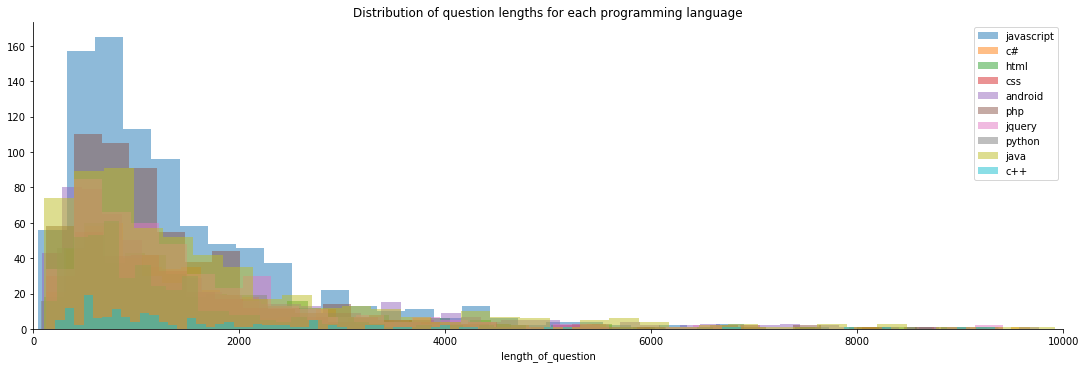

In [751]:
grid = sns.FacetGrid(question_length_df, hue = 'tag', height = 5, aspect = 3)
grid.map(plt.hist, 'length_of_question', bins = 100, alpha = 0.5)
axes = grid.axes

axes[0,0].set_title('Distribution of question lengths for each programming language')
axes[0,0].set_xlim([0,10000])
axes[0,0].legend()

We observe that most questions are about 1000 characters long. It is rather interesting that a couple of questions with 10000 characters are
categorized under Java.

Users on Stack Overflow can earn different badges based on their activity. The top ten easiest gold
badges to earn were queried as follows:

In [753]:
#Top ten easiest gold badges to earn 

badges_query= """
        SELECT name, COUNT(user_id) AS count
        FROM `bigquery-public-data.stackoverflow.badges` 
        WHERE class=1 --1=gold 2=silver 3=bronze 
        GROUP BY name
        ORDER BY count DESC
        LIMIT 10

"""

query_job = client.query(badges_query)
badges_df=query_job.to_dataframe()
badges_df

,name,count
0,Famous Question,715298
1,Great Answer,83625
2,Great Question,39132
3,Fanatic,34820
4,Unsung Hero,23095
5,Electorate,22484
6,Populist,22339
7,Steward,14698
8,Stellar Question,8172
9,Publicist,7431


In [206]:
query3="""SELECT (
  COUNT(case when title like '%?' then 1 end) / 
  COUNT(*)
  ) * 100 as percent_questions 
FROM 
  `bigquery-public-data.stackoverflow.posts_questions`"""

query_job = client.query(query3)
ends_with_df=query_job.to_dataframe()
ends_with_df

,percent_questions
0,21.635369


By extracting the ending character of questions, we can calculate how many questions actually end with
a question mark. We note that only 21% of all questions posted on Stack Overflow end with a question
mark. This low percentage could be due to the fact that most users add more useful details like a code
snippet, output, or error message to the question after posting the actual question.

<font size="5"><b>Data Wrangling and Feature Engineering</b></font>


The entire dataset comprising 4-32 million rows was refined with several conditions to make it more
manageable. The relevant data was obtained by joining the following three tables:<br>
1) bigquery-public-data.stackoverflow.posts_questions <br>
2) bigquery-public-data.stackoverflow.posts_answers<br>
3) bigquery-public-data.stackoverflow.users<br>

WITH answers AS ( <br>
  SELECT <span>&#42;</span>,<br>
    REGEXP_EXTRACT(LOWER(title), '[a-z]+') first_word,<br>
    SUBSTR(title, LENGTH(title))='?' ends_question,<br>
    GREATEST(1, TIMESTAMP_DIFF(answers.first, creation_date, minute)) first_answer_minutes,<br>
    answers.c > 0 was_answered <br>
  FROM (<br>
    SELECT creation_date, title,<br>
      CASE<br>
        WHEN LENGTH(body)<700 THEN 'short'<br>
        WHEN LENGTH(body)<1700 THEN 'medium'<br>
      ELSE 'long'<br>
    END question_length,<br>
      (SELECT MIN(creation_date) first, COUNT(*) c<br>
      FROM `bigquery-public-data.stackoverflow.posts_answers`<br>
      WHERE a.id=parent_id ) answers,<br>
      (SELECT EXTRACT(year FROM creation_date) account_creation_year<br>
      FROM `bigquery-public-data.stackoverflow.users` <br>
      WHERE a.owner_user_id=id ) user,<br>
      SPLIT(tags, '|') tags,<br>
      comment_count,<br>
      view_count<br>
    FROM<br>
      `bigquery-public-data.stackoverflow.posts_questions` a ) )<br><br><br>
      
SELECT <br>
  EXTRACT(year FROM creation_date) AS question_posted,<br>
  first_word,<br>
  ends_question,<br>
  tag,<br>
  view_count,<br>
  comment_count,<br>
  FORMAT_TIMESTAMP('%H', creation_date) hour_utc,<br>
  FORMAT_TIMESTAMP('%A', creation_date) weekday_utc,<br>
  user.account_creation_year,<br>
  question_length, first_answer_minutes<br>
FROM<br>
  answers,<br>
  UNNEST(tags) tag<br>
WHERE<br>
  tag IN ('python','r','mysql','machine-learning','data-science')<br>
  AND first_word IN UNNEST(['how','is','why','what','can', 'i']) <br>
  AND creation_date >= timestamp('2017-01-01') <br>
  AND first_answer_minutes<=43800<br>
  --1 month<br>

The above tables were joined so that we can extract information such as the number of answers, time
taken for the first answer, and user information for each question posted. Each question was further
categorized by its length, starting word, whether it ended with a question mark and its temporal
information. The data set was cleaned based on the following conditions: <br>
1) first word: 'how','is','why','what','can', 'i' <br>
2) Tags are relevant to data science: 'python', 'r','mysql', 'machine-learning','data-science'<br>
3) Questions posted in 2017 and later <br>
3) Only the questions which received answers within a month are considered. <br>


Feature engineering involved categorizing whether each question ended with a question mark, length of
each question (short if <700 characters, medium if <1700 characters, long if >1700 characters), day of
week and time of day it was posted, user account creation date, time taken for the first answer and
computing the chance of getting an answer. The wrangled dataset contained ~240k rows was saved as csv file, which was subseuently read as a Pandas DataFrame.

 

In [757]:
#duration of one month
file_path = 'data/bq-results-3.csv' #time in minutes
data = pd.read_csv(file_path)
data.head()

,question_posted,first_word,ends_question,tag,view_count,comment_count,hour_utc,weekday_utc,account_creation_year,question_length,first_answer_minutes
0,2019,how,False,mysql,114,7,11,Monday,2014.0,short,369
1,2018,how,False,python,81,3,11,Wednesday,2018.0,short,2
2,2018,how,True,python,141,2,7,Wednesday,2016.0,medium,15
3,2019,how,True,python,336,3,18,Tuesday,2014.0,medium,402
4,2019,why,True,python,130,2,9,Friday,2017.0,medium,102


In [758]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243178 entries, 0 to 243177
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   question_posted        243178 non-null  int64  
 1   first_word             243178 non-null  object 
 2   ends_question          243178 non-null  bool   
 3   tag                    243178 non-null  object 
 4   view_count             243178 non-null  int64  
 5   comment_count          243178 non-null  int64  
 6   hour_utc               243178 non-null  int64  
 7   weekday_utc            243178 non-null  object 
 8   account_creation_year  238825 non-null  float64
 9   question_length        243178 non-null  object 
 10  first_answer_minutes   243178 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(4)
memory usage: 18.8+ MB


<font size="5"><b>Data Cleaning</b></font>


In [683]:
data.isnull().sum()

question_posted             0
first_word                  0
ends_question               0
tag                         0
view_count                  0
comment_count               0
hour_utc                    0
weekday_utc                 0
account_creation_year    4353
question_length             0
first_answer_minutes        0
dtype: int64

We observe some null values for the ‘ account_creation_year’ feature. Null values
were probably due to a data logging error. 

In [759]:
data.dropna(inplace=True)

In [760]:
data['account_creation_year']=data['account_creation_year'].astype(int)

#data['account_creation_year'] = pd.to_datetime(data['account_creation_year'], format='%Y')

In [761]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238825 entries, 0 to 243177
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   question_posted        238825 non-null  int64 
 1   first_word             238825 non-null  object
 2   ends_question          238825 non-null  bool  
 3   tag                    238825 non-null  object
 4   view_count             238825 non-null  int64 
 5   comment_count          238825 non-null  int64 
 6   hour_utc               238825 non-null  int64 
 7   weekday_utc            238825 non-null  object
 8   account_creation_year  238825 non-null  int64 
 9   question_length        238825 non-null  object
 10  first_answer_minutes   238825 non-null  int64 
dtypes: bool(1), int64(6), object(4)
memory usage: 20.3+ MB


In [762]:
data.describe()

,question_posted,view_count,comment_count,hour_utc,account_creation_year,first_answer_minutes
count,238825.000000,238825.000000,238825.000000,238825.000000,238825.000000,238825.000000
mean,2018.461430,558.580383,2.042994,12.310847,2016.603576,756.950872
std,1.023267,3563.192185,2.582340,6.263594,2.502777,3400.491044
min,2017.000000,5.000000,0.000000,0.000000,2008.000000,1.000000
25%,2018.000000,41.000000,0.000000,8.000000,2015.000000,7.000000
50%,2019.000000,72.000000,1.000000,13.000000,2017.000000,22.000000
75%,2019.000000,279.000000,3.000000,17.000000,2019.000000,115.000000
max,2020.000000,479597.000000,51.000000,23.000000,2020.000000,43784.000000


<font size="5"><b>Exploratory Data Analysis</b></font>


,question_posted,ends_question,view_count,comment_count,hour_utc,account_creation_year,first_answer_minutes
question_posted,1.000000,0.019314,-0.130346,-0.042280,0.017934,0.387422,-0.004301
ends_question,0.019314,1.000000,0.011625,0.003311,0.021084,-0.053595,0.008166
view_count,-0.130346,0.011625,1.000000,0.001896,-0.003321,-0.070637,0.012859
comment_count,-0.042280,0.003311,0.001896,1.000000,0.028429,0.005547,0.008597
hour_utc,0.017934,0.021084,-0.003321,0.028429,1.000000,-0.019836,0.002377
account_creation_year,0.387422,-0.053595,-0.070637,0.005547,-0.019836,1.000000,-0.042989
first_answer_minutes,-0.004301,0.008166,0.012859,0.008597,0.002377,-0.042989,1.000000


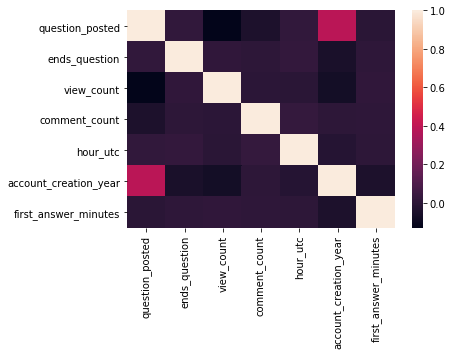

In [688]:
sns.heatmap(data.corr());
data.corr()

We don't see strong correlations between any features. Account_creation_year and no. of questions posted seems to be somewhat correlated. The response variable shows weak correlation to the user account creation year. 

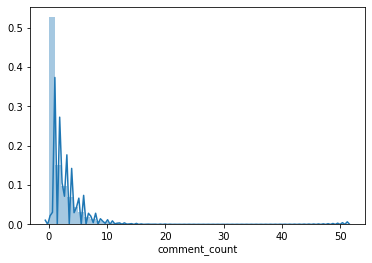

In [689]:
sns.distplot(data['comment_count'], hist=True, kde=True)

From the density plot of the number of comments above, we can see that most of the questions have less than 10 comments/answers. More specifically, 75% of the questions have about 3 or less number of comments. 

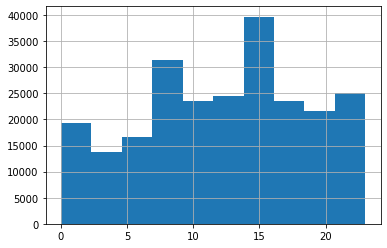

In [690]:
data.hour_utc.hist()

We see an increase in the number of questions posted from mid morning till late night, with a peak the the mid afternoon. We see that 50% of the questions get asked before 1pm and 75% of the questions get asked before
5pm.

In [764]:
data.weekday_utc.value_counts(normalize=True)

Wednesday    0.168383
Thursday     0.165963
Tuesday      0.162898
Friday       0.151400
Monday       0.150457
Sunday       0.101170
Saturday     0.099730
Name: weekday_utc, dtype: float64

In [765]:
data.question_length.value_counts(normalize=True)

medium    0.432597
short     0.338813
long      0.228590
Name: question_length, dtype: float64

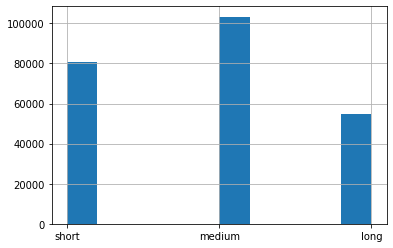

In [769]:
data.question_length.value_counts(normalize=True)
data.question_length.hist()

We observe that most questions are of medium length (i.e. total number of characters between
700-1700) and most questions get posted on Wednesday. On the other hand, long questions (over 1700
characters) are not as common and least number of questions get posted over the weekend.

In [766]:
data.tag.value_counts(normalize=True)

python              0.697142
r                   0.136786
mysql               0.136330
machine-learning    0.025165
data-science        0.004577
Name: tag, dtype: float64

In [693]:
bytag_length=data.groupby("tag").question_length.value_counts(normalize=True)
bytag_length

tag               question_length
data-science      short              0.426349
                  medium             0.397987
                  long               0.175663
machine-learning  short              0.380033
                  medium             0.369884
                  long               0.250083
mysql             medium             0.414755
                  short              0.329801
                  long               0.255444
python            medium             0.433623
                  short              0.345938
                  long               0.220439
r                 medium             0.457849
                  short              0.300967
                  long               0.241184
Name: question_length, dtype: float64

Out of the selected tags, we see that Python questions are most common, while not many questions are tagged under
‘data-science’. Furthermore, we see below that many questions under ‘data-science’ and
‘machine-learning’ tags are short, while all the other tags under consideration have medium length
questions.

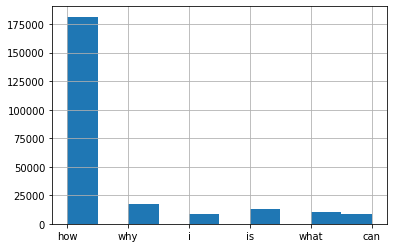

In [768]:
data.first_word.hist()

A significant majority of the questions start with 'how', while the others are on a order of magnitude.

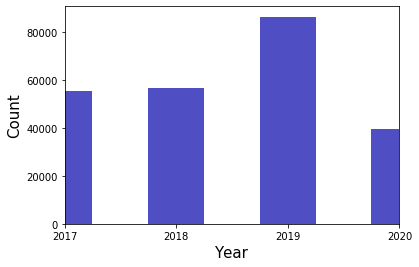

In [770]:
hist,bin_edges = np.histogram(data.question_posted)
bin_edges = np.round(bin_edges,0)

plt.figure(figsize=[6,4])

plt.bar(bin_edges[:-1], hist, width = 0.5, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), max(bin_edges))
plt.xlabel('Year',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(np.arange(2017,2021))
plt.show();

We observe a gradual increase in the number of question posted with the highest so far in 2019. It should be noted that only the first 6 months on 2020 are included.

In [698]:
#one-hot encode categorical values

# Categorical boolean mask
categorical_feature_mask = data.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = data.columns[categorical_feature_mask].tolist()
print(categorical_cols)
cat_columns_idx = [data.columns.get_loc(col) for col in categorical_cols]
print(cat_columns_idx)

['first_word', 'tag', 'weekday_utc', 'question_length']
[1, 3, 7, 9]


In [699]:
# Perform one-hot encode by using the get_dummies function

one_hot_encoded = pd.get_dummies(data, columns=categorical_cols,prefix='C')
#print(dummies.head())
#df_concat=pd.concat([data,dummies],axis=1)
#df_processed=df_concat.drop(data[categorical_cols], axis=1)
print(one_hot_encoded.head())
print(one_hot_encoded.columns)
one_hot_encoded.info()

   question_posted  ends_question  view_count  comment_count  hour_utc  \
0             2019          False         114              7        11   
1             2018          False          81              3        11   
2             2018           True         141              2         7   
3             2019           True         336              3        18   
4             2019           True         130              2         9   

   account_creation_year  first_answer_minutes  C_can  C_how  C_i  ...  \
0                   2014                   369      0      1    0  ...   
1                   2018                     2      0      1    0  ...   
2                   2016                    15      0      1    0  ...   
3                   2014                   402      0      1    0  ...   
4                   2017                   102      0      0    0  ...   

   C_Friday  C_Monday  C_Saturday  C_Sunday  C_Thursday  C_Tuesday  \
0         0         1           0       

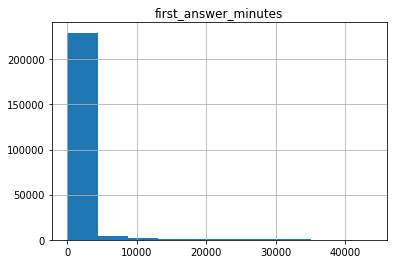

In [777]:
#Distribution of response variable 

# The original histogram
one_hot_encoded[['first_answer_minutes']].hist()
plt.show()


The response variable distribution is extremely right skewed. We know that 50% of the questions get answered within 20 minutes or so, while 75% of the questions get answered in less than 2 hours. 

<font size="5"><b>Machine Learning Modeling</b></font>


The dataset was split into an 80% train and a 20% test set. For this regression analysis, we focus on
linear and tree-based Machine Learning algorithms.
Standardization, hyperparameter tuning, and 5-fold cross-validation were applied to each model. The
model accuracy was measured by calculating the root mean squared error (RMSE) value and mean absolute error (MSE) for each
model for the train and test set. Additionally, the actual and predicted values are plotted for the train
and test set for each model.

In [778]:
# initialize a score table to log the performance of various algorithms
models = ['LinearRegression','Lasso','Ridge','DecisionTreeRegressor','RandomForestRegressor','GradientBoostingRegressor']
score_table = pd.DataFrame(index = models, columns= ['rmse_train','rmse_test','mae_train','mae_test'])

In [702]:
#Function to compute and plot results
#Plot the performance for both training and test datasets
def plot_result(model_name,y_train, train_pred, y_test, test_pred):
    
    # compute the performance
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)

    mae_train = MAE(y_train, train_pred)
    mse_train = MSE(y_train, train_pred)
    rmse_train=np.sqrt(mse_train)

    mae_test = MAE(y_test, test_pred)
    mse_test = MSE(y_test, test_pred)   
    rmse_test=np.sqrt(mse_test)

#    score_table.loc[model_name,:] = r2_train, r2_test, mae_train, mae_test
    score_table.loc[model_name,:] = rmse_train, rmse_test, mae_train, mae_test
    
    ax=sns.residplot(y_test, test_pred, color="b")
    ax.set(xlabel='Time to answer', ylabel='Residual', title='Residual Plot')
    
    # plot the predicted values vs actual for both training and test sets for 1000 points
    fig = plt.figure(figsize=(18,5))

    ax1 = fig.add_subplot(121) # plot training set vs prediction
    ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
    ax1.plot(X_train.index, train_pred, color='red',alpha=0.5);
    ax1.set_xlim([X_train.index[0],X_train.index[1000]]); 
    ax1.set_xlabel('First 500 points of the training set');
    ax1.set_ylabel('Time to answer');
    ax1.legend(['actual','predicted']);
    ax1.set_title('Training set: RMSE={:.2f}, MAE={:.2f}'.format(rmse_train, mae_train));

    ax2 = fig.add_subplot(122) # plot test set vs prediction
    ax2.plot(X_test.index, y_test, color='blue',alpha=0.5);
    ax2.plot(X_test.index, test_pred, color='red',alpha=0.5);
    ax2.set_xlim([X_test.index[-1000],X_test.index[-1]]); 
    ax2.set_xlabel('Last 500 points of the test set');
    ax2.set_ylabel('Time to answer');
    ax2.legend(['actual','predicted']);
    ax2.set_title('Test set: RMSE={:.2f}, MAE={:.2f}'.format(rmse_test, mae_test));
    plt.show()
    plt.clf()
    


In [703]:
#linear Regression model


def linear_regression(X_train, y_train_log, X_test):

  #  lr_model = Pipeline([('scaler', MinMaxScaler()),('lr_model',LinearRegression())])
  
    lr_model = Pipeline([('scaler', StandardScaler()),('lr_model',LinearRegression())])
    #Fit the model on the log transformed y
    #lr_model.fit(X_train, y_train)
    lr_model.fit(X_train, y_train_log)

    #Predict and convert back to real
    #train_pred = lr_model.predict(X_train)
    train_pred_log = lr_model.predict(X_train)
    train_pred=np.exp(train_pred_log) 

    #repeat on test set 
    #test_pred = lr_model.predict(X_test)
    test_pred_log = lr_model.predict(X_test)
    test_pred = np.exp(test_pred_log)
    
    plot_result('LinearRegression', y_train, train_pred, y_test, test_pred)

    feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':lr_model.named_steps.lr_model.coef_})
    print(feature_rank.sort_values('coefficient',ascending=False))

In [704]:
# LASSO

def lasso(X_train, y_train_log, X_test):
    
    lasso= Pipeline([('scaler', StandardScaler()),('lasso',Lasso())])

    # grid search of parameter alpha to improve lasso model
    parameters = {'lasso__alpha': np.arange(0.01, 1, 0.05)}
    lasso_cv = GridSearchCV(estimator=lasso, param_grid=parameters, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
    lasso_cv.fit(X_train, y_train_log)

    #Predict and convert back to real
    train_pred_log = lasso_cv.predict(X_train)
    train_pred=np.exp(train_pred_log) 

    #repeat on test set 
    test_pred_log = lasso_cv.predict(X_test)
    test_pred = np.exp(test_pred_log)

    plot_result('Lasso', y_train, train_pred, y_test, test_pred)

    #Extract the best estimators
    best_hyperparameters=lasso_cv.best_params_
    print('Best hyperparameters:',best_hyperparameters)
    best_model = lasso_cv.best_estimator_
    print('Best model:',best_model)
    print('Corresponding score:', lasso_cv.best_score_)

    #Feature importances
    feature_rank = pd.Series(data=lasso_cv.best_estimator_.named_steps.lasso.coef_, index= X_train.columns)
    feature_rank_sorted = feature_rank.sort_values(ascending=False)
    print(feature_rank_sorted)


In [705]:
# RIDGE

def ridge(X_train, y_train_log, X_test):
    
    ridge= Pipeline([('scaler', StandardScaler()),('ridge',Ridge())])

    # grid search of parameter alpha to improve lasso model
    parameters = {'ridge__alpha': np.arange(7000, 9000, 100)}
    ridge_cv = GridSearchCV(estimator=ridge, param_grid=parameters, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
    ridge_cv.fit(X_train, y_train_log)

    #Predict and convert back to real
    train_pred_log = ridge_cv.predict(X_train)
    train_pred=np.exp(train_pred_log) 


    #repeat on test set 
    test_pred_log = ridge_cv.predict(X_test)
    test_pred = np.exp(test_pred_log)

    plot_result('Ridge', y_train, train_pred, y_test, test_pred)

    #Extract the best estimators
    best_hyperparameters=ridge_cv.best_params_
    print('Best hyperparameters:',best_hyperparameters)
    best_model = ridge_cv.best_estimator_
    print('Best model:',best_model)
    print('Corresponding score:', ridge_cv.best_score_)

    #Feature importances
    feature_rank = pd.Series(data=ridge_cv.best_estimator_.named_steps.ridge.coef_, index= X_train.columns)
    feature_rank_sorted = feature_rank.sort_values(ascending=False)
    print(feature_rank_sorted)

In [706]:
#decision tree model

def decisiontree(X_train, y_train_log, X_test):

    dt_model = Pipeline([('scaler', StandardScaler()),('dt_model',DecisionTreeRegressor(random_state=1))])
    #Hyper-parameter tuning and 5-fold cross-validation
    params_dt = {'dt_model__max_leaf_nodes': [150, 250, 300],'dt_model__max_features': ['log2', 'auto', 'sqrt'],'dt_model__min_samples_leaf': [10, 30, 50]}
    grid_dt=GridSearchCV(estimator=dt_model, param_grid=params_dt, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)

    grid_dt.fit(X_train, y_train_log)

    #Predict and convert back to real
    train_pred_log = grid_dt.predict(X_train)
    train_pred=np.exp(train_pred_log) 

    #repeat on test set 
    test_pred_log = grid_dt.predict(X_test)
    test_pred = np.exp(test_pred_log)

    plot_result('DecisionTreeRegressor', y_train, train_pred, y_test, test_pred)

    #Extract the best estimators
    best_hyperparameters=grid_dt.best_params_
    print('Best hyperparameters:',best_hyperparameters)
    best_model = grid_dt.best_estimator_
    print('Best model:',best_model)
    print('Corresponding score:', grid_dt.best_score_)

    #Feature importances
    feature_rank = pd.Series(data=grid_dt.best_estimator_.named_steps.dt_model.feature_importances_, index= X_train.columns)
    feature_rank_sorted = feature_rank.sort_values(ascending=False)
    print(feature_rank_sorted)

In [707]:
# Ensemble Learning 1
#Bagging (bootstrap sampling-draw with replacement with same algorithm)

def randomforest(X_train, y_train_log, X_test):
    #Instantiate model
    rf_model = Pipeline([('scaler', StandardScaler()),('rf_model',RandomForestRegressor(random_state=1))])
    
    #Hyper-parameter tuning and 5-fold cross-validation
    params_rf = {'rf_model__n_estimators': [100, 200, 300],'rf_model__max_features': ['log2', 'auto', 'sqrt'],'rf_model__min_samples_leaf': [10, 30, 50]}
    grid_rf=GridSearchCV(estimator=rf_model, param_grid=params_rf, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)

    #Fit
    grid_rf.fit(X_train, y_train_log)

    #Predict and convert back to real
    train_pred_log = grid_rf.predict(X_train)
    train_pred=np.exp(train_pred_log) 

    #repeat on test set 
    test_pred_log = grid_rf.predict(X_test)
    test_pred = np.exp(test_pred_log)

    plot_result('RandomForestRegressor', y_train, train_pred, y_test, test_pred)

    #Extract the best estimators
    best_hyperparameters=grid_rf.best_params_
    print('Best hyperparameters:',best_hyperparameters)
    best_model = grid_rf.best_estimator_
    print('Best model:',best_model)
    print('Corresponding score:', grid_rf.best_score_)


    #Feature importances
    feature_rank = pd.Series(data=grid_rf.best_estimator_.named_steps.rf_model.feature_importances_, index= X_train.columns)
    feature_rank_sorted = feature_rank.sort_values(ascending=False)
    print(feature_rank_sorted)

In [708]:
def gradientboosting(X_train, y_train_log, X_test):
    
    # Instantiate gb
    gb_model = Pipeline([('scaler', StandardScaler()),('gb_model',GradientBoostingRegressor(random_state=1))])

    #Hyper-parameter tuning and 5-fold cross-validation
    params_gb = {'gb_model__n_estimators': [100, 500, 1000],'gb_model__max_depth': [5,10,20],'gb_model__learning_rate': [0.01,0.1,1.0]}
    grid_gb=GridSearchCV(estimator=gb_model, param_grid=params_gb, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)

    grid_gb.fit(X_train, y_train_log)

    #Predict and convert back to real
    train_pred_log = grid_gb.predict(X_train)
    train_pred=np.exp(train_pred_log) 

    #repeat on test set 
    test_pred_log = grid_gb.predict(X_test)
    test_pred = np.exp(test_pred_log)

    plot_result('GradientBoostingRegressor', y_train, train_pred, y_test, test_pred)

    #Extract the best estimators
    best_hyperparameters=grid_gb.best_params_
    print('Best hyperparameters:',best_hyperparameters)
    best_model = grid_gb.best_estimator_
    print('Best model:',best_model)
    print('Corresponding score:', grid_gb.best_score_)

    #Feature importances
    feature_rank = pd.Series(data=grid_gb.best_estimator_.named_steps.gb_model.feature_importances_, index= X_train.columns)
    feature_rank_sorted = feature_rank.sort_values(ascending=False)
    print(feature_rank_sorted)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238824 entries, 0 to 243177
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   question_posted        238824 non-null  int64
 1   ends_question          238824 non-null  bool 
 2   view_count             238824 non-null  int64
 3   comment_count          238824 non-null  int64
 4   hour_utc               238824 non-null  int64
 5   account_creation_year  238824 non-null  int64
 6   first_answer_minutes   238824 non-null  int64
 7   C_can                  238824 non-null  uint8
 8   C_how                  238824 non-null  uint8
 9   C_i                    238824 non-null  uint8
 10  C_is                   238824 non-null  uint8
 11  C_what                 238824 non-null  uint8
 12  C_why                  238824 non-null  uint8
 13  C_data-science         238824 non-null  uint8
 14  C_machine-learning     238824 non-null  uint8
 15  C_mysql          

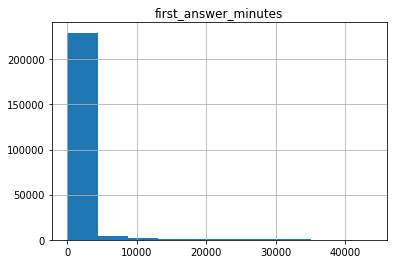

In [709]:
#Part 1: Consider the entire dataset
    
# Find the 90th quantile
quantile = one_hot_encoded['first_answer_minutes'].quantile(1.0)

# Trim the outliers
one_hot_encoded_trimmed= one_hot_encoded[one_hot_encoded['first_answer_minutes'] < quantile]

one_hot_encoded_trimmed.info()

# The trimmed histogram
one_hot_encoded_trimmed[['first_answer_minutes']].hist()
plt.show()

In [710]:
# Split into test and training data

train, test = train_test_split(one_hot_encoded_trimmed, test_size=0.2, random_state=1)

print(len(train), len(test))

#reset indices
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

191059 47765


In [711]:
#log transform the dependent variable only on the training set
y_train = train['first_answer_minutes']
y_train_log=np.log(y_train)
X_train=train[train.columns.difference(['first_answer_minutes'])]

y_test=test['first_answer_minutes']
X_test=test[test.columns.difference(['first_answer_minutes'])]

Linear Regression:



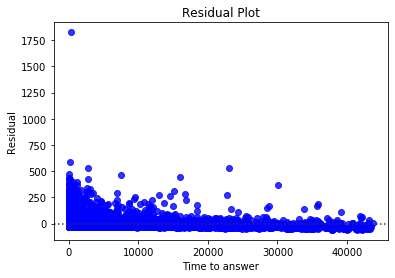

/Users/varuni/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


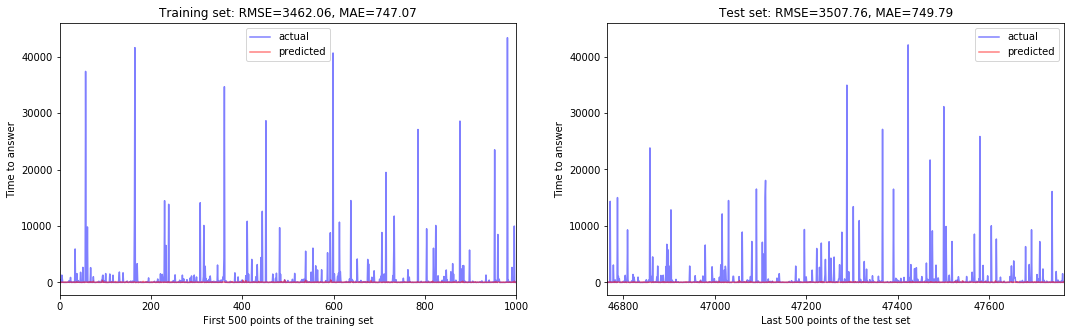

                  feature   coefficient
16               C_python  1.458713e+10
17                    C_r  1.089643e+10
15                C_mysql  1.089449e+10
13     C_machine-learning  4.975283e+09
8          C_data-science  2.152278e+09
22          comment_count  1.261340e-01
25        question_posted  7.322377e-02
26             view_count  1.022546e-02
23          ends_question  1.021118e-02
24               hour_utc -5.165994e-02
21  account_creation_year -1.652040e-01
10                    C_i -2.760595e+09
7                   C_can -2.848524e+09
19                 C_what -3.049932e+09
11                   C_is -3.383636e+09
20                  C_why -3.883641e+09
9                   C_how -6.427416e+09
2              C_Saturday -8.970001e+09
3                C_Sunday -9.006588e+09
1                C_Monday -1.067313e+10
0                C_Friday -1.071773e+10
5               C_Tuesday -1.104632e+10
4              C_Thursday -1.112710e+10
6             C_Wednesday -1.118153e+10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished


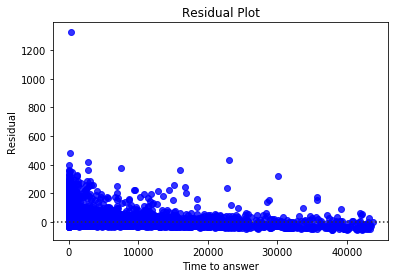

/Users/varuni/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


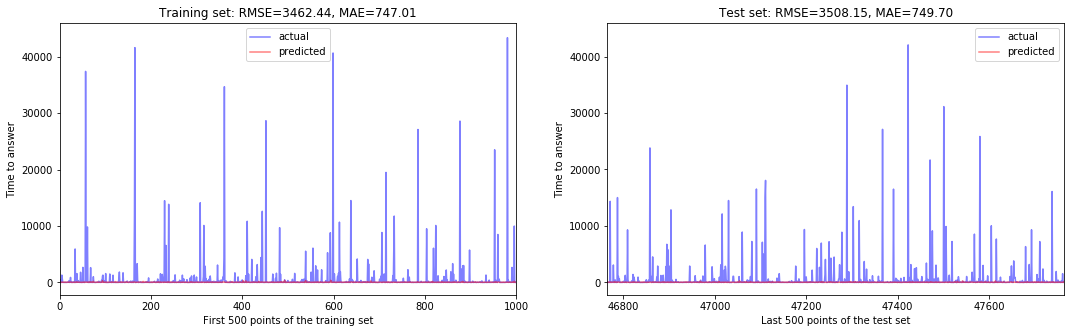

Best hyperparameters: {'lasso__alpha': 0.01}
Best model: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)
Corresponding score: -1.6689521862760295
C_long                   0.307506
C_machine-learning       0.195521
comment_count            0.112694
question_posted          0.056983
C_Saturday               0.052145
C_data-science           0.041636
C_r                      0.040154
C_Sunday                 0.032668
C_can                    0.030926
C_is                     0.027987
ends_question            0.001183
C_Monday                -0.000000
C_Thursday              -0.000000
C_Tuesday 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.6s finished


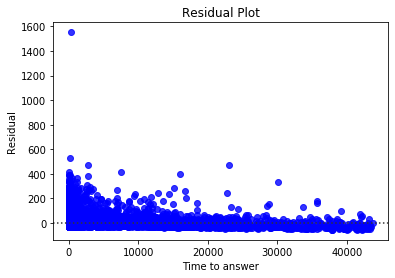

/Users/varuni/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


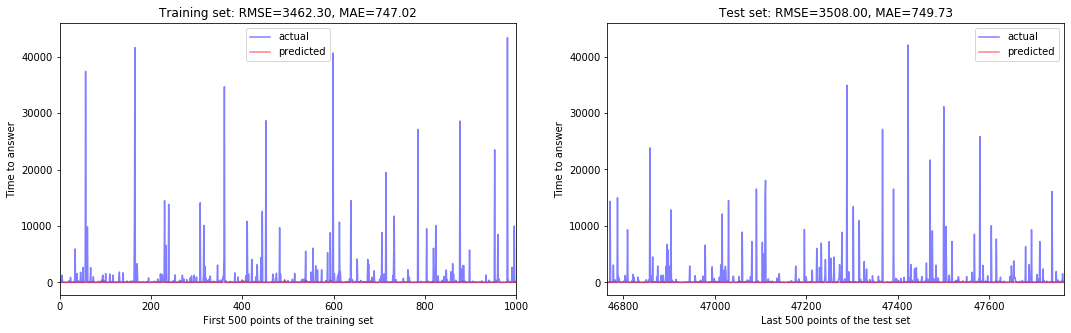

Best hyperparameters: {'ridge__alpha': 7000}
Best model: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=7000, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)
Corresponding score: -1.6682898107441508
C_long                   0.285404
C_machine-learning       0.195808
comment_count            0.120876
question_posted          0.068423
C_Saturday               0.051572
C_data-science           0.048595
C_can                    0.046265
C_is                     0.042347
C_r                      0.041546
C_Sunday                 0.032740
C_how                    0.016180
ends_question            0.010345
view_count               0.009827
C_Friday                -0.004631
C_python                -0.010154
C_Monday               

<Figure size 432x288 with 0 Axes>

In [712]:
print("Linear Regression:\n")
linear_regression(X_train, y_train_log, X_test)
print("\n\n")
print("Linear Regression with Lasso Regularization:\n")
lasso(X_train, y_train_log, X_test)
print("\n\n")
print("Linear Regression with Ridge Regularization:\n")
ridge(X_train, y_train_log, X_test)
print("\n\n")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   42.3s finished


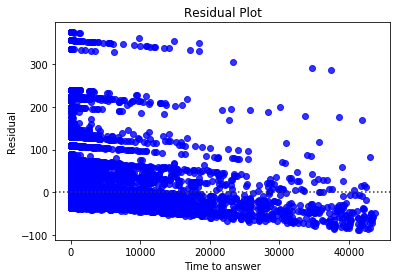

/Users/varuni/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


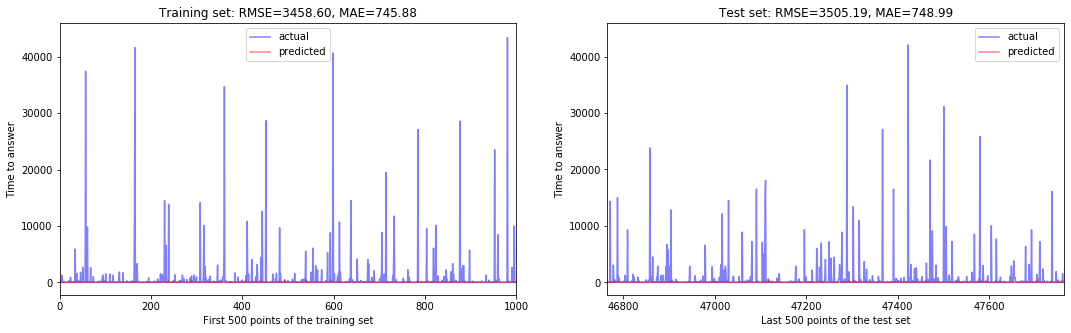

Best hyperparameters: {'dt_model__max_features': 'auto', 'dt_model__max_leaf_nodes': 150, 'dt_model__min_samples_leaf': 30}
Best model: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dt_model',
                 DecisionTreeRegressor(criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=150,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=30, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=1,
                                       splitter='best'))],
         verbose=False)
Corresponding score: -1.6385667877023558
C_long                   0.336080
view_count               0.311224
C_medium        

<Figure size 432x288 with 0 Axes>

In [713]:
decisiontree(X_train, y_train_log, X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 41.6min finished


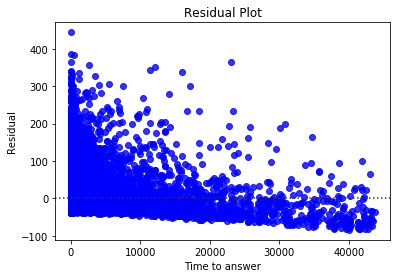

/Users/varuni/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


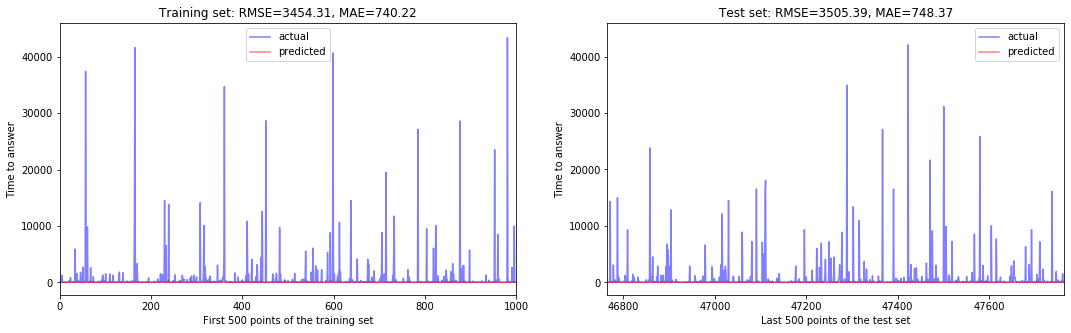

Best hyperparameters: {'rf_model__max_features': 'sqrt', 'rf_model__min_samples_leaf': 10, 'rf_model__n_estimators': 300}
Best model: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rf_model',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=10, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=300, n_jobs=None,
                                       oob_score=False, random_state=1,
                                       verbose=0, warm_start=False))],
         ve

<Figure size 432x288 with 0 Axes>

In [714]:
randomforest(X_train, y_train_log, X_test)

In [715]:
#gradientboosting(X_train, y_train_log, X_test)

In [716]:
print(score_table)

                          rmse_train rmse_test mae_train mae_test
LinearRegression             3462.06   3507.76    747.07  749.793
Lasso                        3462.44   3508.15   747.011  749.696
Ridge                         3462.3      3508    747.02   749.73
DecisionTreeRegressor         3458.6   3505.19   745.876  748.992
RandomForestRegressor        3454.31   3505.39    740.22  748.373
GradientBoostingRegressor        NaN       NaN       NaN      NaN


1018.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 214925 entries, 0 to 243177
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   question_posted        214925 non-null  int64
 1   ends_question          214925 non-null  bool 
 2   view_count             214925 non-null  int64
 3   comment_count          214925 non-null  int64
 4   hour_utc               214925 non-null  int64
 5   account_creation_year  214925 non-null  int64
 6   first_answer_minutes   214925 non-null  int64
 7   C_can                  214925 non-null  uint8
 8   C_how                  214925 non-null  uint8
 9   C_i                    214925 non-null  uint8
 10  C_is                   214925 non-null  uint8
 11  C_what                 214925 non-null  uint8
 12  C_why                  214925 non-null  uint8
 13  C_data-science         214925 non-null  uint8
 14  C_machine-learning     214925 non-null  uint8
 15  C_mysql   

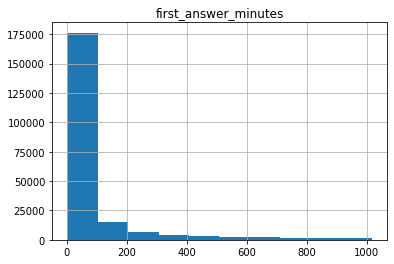

171940 42985


In [717]:
#Part 2: Within time taken to answer 90% questions (about 16 hours)
    
# Find the 90th quantile
quantile = one_hot_encoded['first_answer_minutes'].quantile(0.90)
print(quantile)

# Trim the outliers
one_hot_encoded_trimmed= one_hot_encoded[one_hot_encoded['first_answer_minutes'] < quantile]

one_hot_encoded_trimmed.info()

# The trimmed histogram
one_hot_encoded_trimmed[['first_answer_minutes']].hist()
plt.show()

# Split into test and training data

train, test = train_test_split(one_hot_encoded_trimmed, test_size=0.2, random_state=1)

print(len(train), len(test))

#reset indices
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)


#log transform the dependent variable only on the training set
y_train = train['first_answer_minutes']
y_train_log=np.log(y_train)
X_train=train[train.columns.difference(['first_answer_minutes'])]

y_test=test['first_answer_minutes']
X_test=test[test.columns.difference(['first_answer_minutes'])]

Linear Regression:



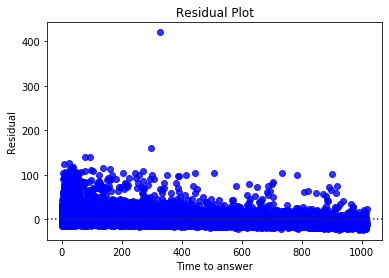

/Users/varuni/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


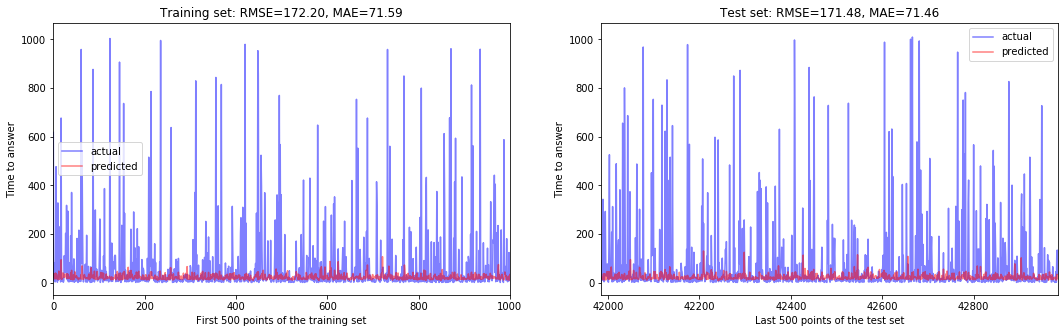

                  feature   coefficient
14               C_medium  4.470677e+10
18                C_short  4.297230e+10
12                 C_long  3.715843e+10
6             C_Wednesday  2.754052e+09
4              C_Thursday  2.737765e+09
5               C_Tuesday  2.716356e+09
0                C_Friday  2.635972e+09
1                C_Monday  2.621932e+09
3                C_Sunday  2.219386e+09
2              C_Saturday  2.197654e+09
22          comment_count  9.734482e-02
25        question_posted  4.342641e-02
23          ends_question  1.955822e-03
26             view_count  1.299072e-03
21  account_creation_year -6.580280e-02
24               hour_utc -7.896635e-02
8          C_data-science -3.161068e+09
10                    C_i -6.944248e+09
7                   C_can -6.979256e+09
13     C_machine-learning -7.178029e+09
19                 C_what -7.576349e+09
11                   C_is -8.332533e+09
20                  C_why -9.647430e+09
9                   C_how -1.593200e+10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.9s finished


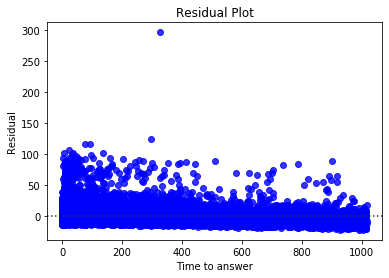

/Users/varuni/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


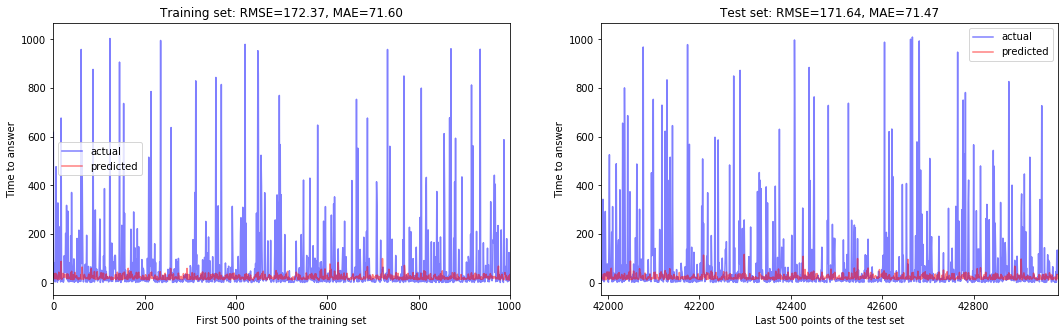

Best hyperparameters: {'lasso__alpha': 0.01}
Best model: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)
Corresponding score: -1.246106549068728
C_long                   0.217339
C_machine-learning       0.154026
comment_count            0.083402
C_r                      0.055265
C_Saturday               0.045973
C_Sunday                 0.042099
question_posted          0.027905
C_data-science           0.023903
C_is                     0.014989
C_can                    0.010440
C_Monday                 0.000000
C_Thursday              -0.000000
C_Tuesday                0.000000
C_Wednesday

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.4s finished


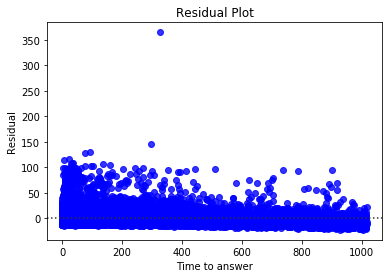

/Users/varuni/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


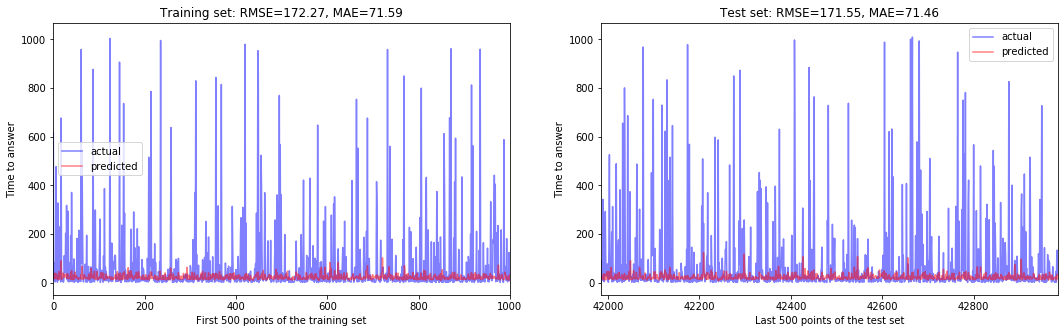

Best hyperparameters: {'ridge__alpha': 7000}
Best model: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=7000, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)
Corresponding score: -1.2452091512079868
C_long                   0.214721
C_machine-learning       0.151299
comment_count            0.092757
C_r                      0.045950
C_Saturday               0.044583
question_posted          0.040916
C_Sunday                 0.040753
C_data-science           0.029702
C_is                     0.028917
C_can                    0.024789
C_how                    0.013707
ends_question            0.002093
view_count               0.001179
C_medium                -0.003432
C_i                     -0.007689
C_Monday               

<Figure size 432x288 with 0 Axes>

In [718]:
print("Linear Regression:\n")
linear_regression(X_train, y_train_log, X_test)
print("\n\n")
print("Linear Regression with Lasso Regularization:\n")
lasso(X_train, y_train_log, X_test)
print("\n\n")
print("Linear Regression with Ridge Regularization:\n")
ridge(X_train, y_train_log, X_test)
print("\n\n")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   36.8s finished


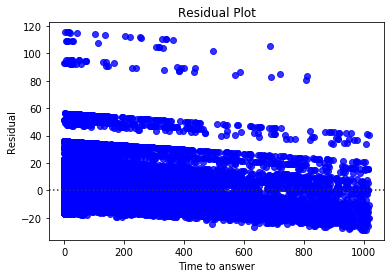

/Users/varuni/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


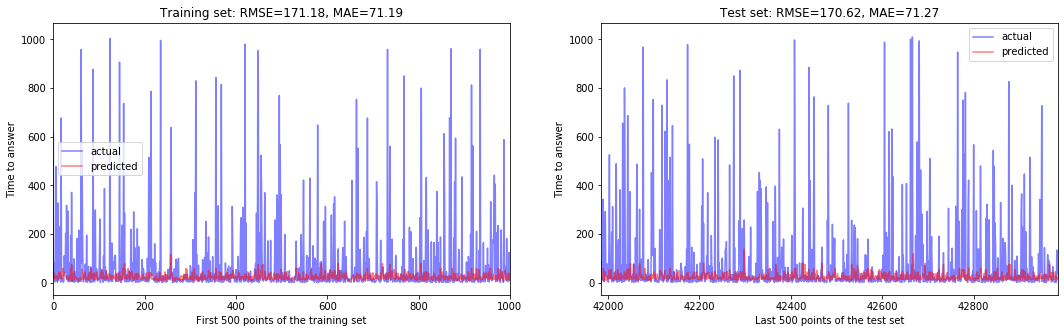

Best hyperparameters: {'dt_model__max_features': 'auto', 'dt_model__max_leaf_nodes': 150, 'dt_model__min_samples_leaf': 50}
Best model: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dt_model',
                 DecisionTreeRegressor(criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=150,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=50, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=1,
                                       splitter='best'))],
         verbose=False)
Corresponding score: -1.232402659418208
C_long                   0.354063
view_count               0.189602
C_medium         

<Figure size 432x288 with 0 Axes>

In [719]:
decisiontree(X_train, y_train_log, X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 36.0min finished


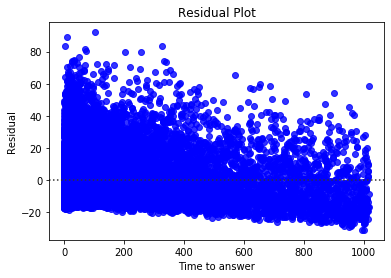

/Users/varuni/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


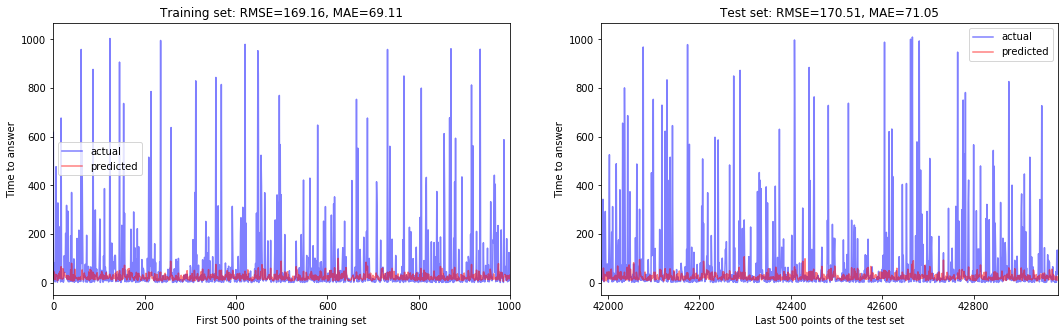

Best hyperparameters: {'rf_model__max_features': 'sqrt', 'rf_model__min_samples_leaf': 10, 'rf_model__n_estimators': 300}
Best model: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rf_model',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=10, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=300, n_jobs=None,
                                       oob_score=False, random_state=1,
                                       verbose=0, warm_start=False))],
         ve

<Figure size 432x288 with 0 Axes>

In [720]:
randomforest(X_train, y_train_log, X_test)

In [779]:
#gradientboosting(X_train, y_train_log, X_test)

In [722]:
print(score_table)

                          rmse_train rmse_test mae_train mae_test
LinearRegression             172.202   171.483    71.588  71.4566
Lasso                        172.372   171.639   71.6015  71.4651
Ridge                        172.274   171.548   71.5868  71.4551
DecisionTreeRegressor        171.179    170.62   71.1881  71.2653
RandomForestRegressor        169.162    170.51   69.1129  71.0462
GradientBoostingRegressor        NaN       NaN       NaN      NaN


In conclusion, we have successfully developed a model to predict the response rate for a question
posted on Stack Overflow. Stack Overflow is a platform used by millions of computer scientists
worldwide, and usually post questions while working on a project, thus anticipating an answer as soon
as possible. It is helpful to know if there are some aspects of the question that would lead to a faster
helpful answer, thus enabling the poster to design the question as such. We have evaluated multiple
supervised machine learning algorithms, and evaluated each model for accuracy and efficiency. The random forest algorithm gives the best results wiith lowest MAE and RMSE. As we are trying to predict how long it would take for a question to get an answer, the error scales linearly, where MAE is a good metric. Hence, with the random forest model, we can predict with time with an error of one hour. Given the range of values of the response variable, this is excellent. 

Additionally, there seems to overfitting on a very small scale, which can be addressed by increaing the number of cross validation folds. We can
conclude that the view count, the time of day the questoin is posted and length of the question have
the greatest impact on how long it would take to get a response. By identifying these features, can perhaps flagging the user to 'improve' the question just before posting it, will lead to faster response times. Thi will lead to higher user engagement, thus increase the revenue for Stack Overflow. 
